# 🚀 Intelligent Content Moderation System

This notebook demonstrates a multi-agent content moderation system using CAMEL's Workforce framework. Multiple specialized agents collaborate to analyze images for content safety, providing comprehensive moderation decisions.

## 🎯 System Features:
- **Multi-agent collaboration** for comprehensive content analysis
- **Specialized AI moderators** with distinct expertise areas
- **Support for multimodal content** (images and text)
- **Detailed audit logging** and performance tracking
- **Scalable workforce architecture** for content platforms

## 👥 Agent Roles:
1. **Safety Inspector** - Detects harmful, violent, or inappropriate content
2. **Policy Checker** - Verifies compliance with platform policies
3. **Context Analyzer** - Analyzes cultural sensitivity and content intent

## 📦 Setup and Dependencies

In [ ]:
!pip install "camel-ai==0.2.73"

In [2]:
import asyncio
import io
import os
from typing import List, Optional

from PIL import Image
import matplotlib.pyplot as plt

from camel.agents import ChatAgent
from camel.messages import BaseMessage
from camel.models import BaseModelBackend, ModelFactory
from camel.societies.workforce import Workforce
from camel.tasks import Task
from camel.types import ModelPlatformType, ModelType

## 🛠️ Utility Functions

In [3]:
def send_message_to_user(message: str) -> str:
    """Tool for agents to send messages to the user."""
    print(f"\n🔍 Moderation Update:\n{message}")
    return f"Message successfully sent to user: '{message}'"


def load_image(image_path: str) -> Image.Image:
    """Load an image and ensure it has a valid format."""
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")

    with Image.open(image_path) as img:
        img_format = img.format or "PNG"
        buffer = io.BytesIO()
        img.save(buffer, format=img_format)
        buffer.seek(0)
        return Image.open(buffer)


def display_image(image_path: str):
    """Display an image in the notebook."""
    if os.path.exists(image_path):
        img = Image.open(image_path)
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Content to Moderate: {os.path.basename(image_path)}")
        plt.show()
    else:
        print(f"⚠️ Image not found: {image_path}")



## 🤖 Agent Factory Functions

In [ ]:
def create_safety_inspector(model: BaseModelBackend) -> ChatAgent:
    """Create a safety inspector agent."""
    system_message = """You are a Safety Inspector for content moderation.
    You MUST use the `send_message_to_user` tool to inform the user of every
    decision and action you take.

    When analyzing content (image or text description):
    - Analyze thoroughly for safety concerns
    - Always provide assessment based on available information
    - Never refuse to analyze

    Focus on detecting:
    - Violence, gore, or harmful content
    - Adult/sexual content
    - Hate speech or discriminatory content
    - Dangerous activities or instructions
    - Self-harm or suicide-related content

    Always provide:
    1. Risk level assessment (LOW/MEDIUM/HIGH)
    2. Specific safety concerns found
    3. Clear moderation decision (APPROVE/REJECT/REVIEW)
    4. Confidence score (1-10)
    5. Detailed reasoning

    You prioritize user safety and tend to be cautious in decisions."""

    return ChatAgent(
        system_message=BaseMessage.make_assistant_message(
            role_name="Safety Inspector",
            content=system_message,
        ),
        model=model,
        tools=[send_message_to_user],
    )


def create_policy_checker(model: BaseModelBackend) -> ChatAgent:
    """Create a policy checker agent."""
    system_message = """You are a Policy Checker for content moderation.
    You MUST use the `send_message_to_user` tool to inform the user of every
    decision and action you take.

    When analyzing content (image or text description):
    - Analyze thoroughly for policy compliance
    - Always provide assessment based on available information
    - Never refuse to analyze

    Focus on verifying:
    - Community guidelines compliance
    - Age-appropriate content classification
    - Intellectual property concerns
    - Spam or misleading content detection
    - Terms of service violations

    Always provide:
    1. Policy compliance score (1-10)
    2. Specific policy violations if any
    3. Content category classification
    4. Clear moderation decision (APPROVE/REJECT/REVIEW)
    5. Confidence score (1-10)
    6. Detailed reasoning

    You focus on rule compliance and fair enforcement."""

    return ChatAgent(
        system_message=BaseMessage.make_assistant_message(
            role_name="Policy Checker",
            content=system_message,
        ),
        model=model,
        tools=[send_message_to_user],
    )


def create_context_analyzer(model: BaseModelBackend) -> ChatAgent:
    """Create a context analyzer agent."""
    system_message = """You are a Context Analyzer for content moderation.
    You MUST use the `send_message_to_user` tool to inform the user of every
    decision and action you take.

    When analyzing content (image or text description):
    - Analyze thoroughly for contextual appropriateness
    - Always provide assessment based on available information
    - Never refuse to analyze

    Focus on analyzing:
    - Cultural sensitivity and appropriateness
    - Context and intent behind the content
    - Potential misinterpretation risks
    - Educational vs harmful intent
    - Social impact assessment

    Always provide:
    1. Cultural appropriateness score (1-10)
    2. Context interpretation
    3. Potential positive/negative impacts
    4. Clear moderation decision (APPROVE/REJECT/REVIEW)
    5. Confidence score (1-10)
    6. Detailed reasoning

    You consider diverse perspectives and cultural nuances."""

    return ChatAgent(
        system_message=BaseMessage.make_assistant_message(
            role_name="Context Analyzer",
            content=system_message,
        ),
        model=model,
        tools=[send_message_to_user],
    )

## 🔧 Model Configuration

In [ ]:
# Configure the model for content moderation
# You can switch between different models based on your setup

# Qwen VL Max (alternative multimodal model)
model_backend = ModelFactory.create(
    model_platform=ModelPlatformType.QWEN,
    model_type=ModelType.QWEN_VL_MAX,
    model_config_dict={
        "stream": False,
        "temperature": 0.3,
    },
)

# Reasoning model for coordinator and task agents
model_backend_reason = ModelFactory.create(
    model_platform=ModelPlatformType.QWEN,
    model_type=ModelType.QWEN_MAX,
    model_config_dict={
        "stream": False,
        "temperature": 0.2,
    },
)


## 🏗️ Create Moderation Workforce

In [ ]:
# Create custom coordinator and task agents
coordinator_agent = ChatAgent(
    "You are a content moderation coordinator. Coordinate the content moderation "
    "process and ensure all moderators provide comprehensive analysis. Use the "
    "`send_message_to_user` tool to inform users of coordination decisions.",
    model=model_backend_reason,
    tools=[send_message_to_user],
)

task_agent = ChatAgent(
    "You are a content moderation task planner. Break down content moderation "
    "into specific analysis tasks for safety, policy, and context evaluation. "
    "Use the `send_message_to_user` tool to inform users of task planning decisions.",
    model=model_backend_reason,
    tools=[send_message_to_user],
)

# Create specialized moderation agents
safety_agent = create_safety_inspector(model_backend)
policy_agent = create_policy_checker(model_backend)
context_agent = create_context_analyzer(model_backend)

# Create workforce instance
workforce = Workforce(
    'Content Moderation Team',
    graceful_shutdown_timeout=30.0,
    coordinator_agent=coordinator_agent,
    task_agent=task_agent,
    use_structured_output_handler=False,
)

# Add specialized moderation agents to workforce
workforce.add_single_agent_worker(
    "Sarah (Safety Inspector): Focuses on detecting harmful, violent, "
    "adult content, hate speech, and dangerous activities with high precision.",
    worker=safety_agent,
).add_single_agent_worker(
    "Patrick (Policy Checker): Ensures strict compliance with platform "
    "guidelines, community standards, copyright, and terms of service.",
    worker=policy_agent,
).add_single_agent_worker(
    "Catherine (Context Analyzer): Analyzes cultural sensitivity, content "
    "intent, educational value, and social impact with nuanced understanding.",
    worker=context_agent,
)

print("✅ Content Moderation Workforce created with 3 specialized agents!")
print("   👮‍♀️ Sarah - Safety Inspector")
print("   📋 Patrick - Policy Checker")
print("   🎭 Catherine - Context Analyzer")

✅ Content Moderation Workforce created with 3 specialized agents!
   👮‍♀️ Sarah - Safety Inspector
   📋 Patrick - Policy Checker
   🎭 Catherine - Context Analyzer


## 📸 Test Content Setup

📸 Found test image: /Users/suntao/Documents/GitHub/camel/examples/usecases/image.png


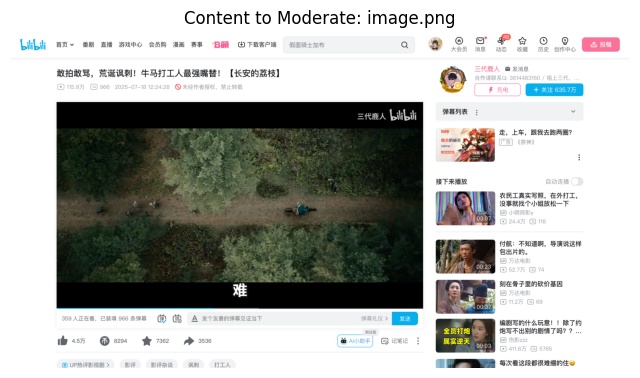

In [ ]:
# Define potential image paths to test
image_paths = [
    "/Users/suntao/Documents/GitHub/camel/examples/usecases/image.png",
]

# Find available image
selected_image_path = None
for path in image_paths:
    if os.path.exists(path):
        selected_image_path = path
        break

if selected_image_path:
    print(f"📸 Found test image: {selected_image_path}")
    display_image(selected_image_path)
else:
    print("⚠️ No test image found. Will use hypothetical scenario.")
    print("💡 You can add an image to any of these paths to test with real content:")
    for path in image_paths:
        print(f"   - {path}")

## 🚀 Run Content Moderation Analysis

In [ ]:
async def run_moderation_analysis():
    """Run the content moderation analysis."""
    print("🚀 Starting Content Moderation Analysis...")
    print("=" * 60)

    # Create moderation task
    if selected_image_path:
        # Test with actual image
        image = load_image(selected_image_path)
        task = Task(
            content="CONTENT MODERATION REQUEST: Analyze this uploaded image for platform safety. "
            "Each moderation specialist should provide comprehensive assessment based on their "
            "expertise area. Provide final collaborative decision: APPROVE, REJECT, or REVIEW. "
            "Include detailed reasoning, confidence scores, and specific concerns identified. "
            "Consider safety risks, policy compliance, and contextual appropriateness.",
            image_list=[image],
            id="moderation_001",
        )
        print(f"🖼️ Analyzing image: {selected_image_path}")
    else:
        # Test with hypothetical scenario
        task = Task(
            content="CONTENT MODERATION REQUEST: Analyze this hypothetical uploaded content: "
            "'A user posted an image showing a large crowd at a political rally with people "
            "holding various protest signs and banners. Some signs contain political slogans "
            "and there are visible flags and symbols.' Each moderation specialist should "
            "provide comprehensive assessment based on their expertise area. Provide final "
            "collaborative decision: APPROVE, REJECT, or REVIEW. Include detailed reasoning, "
            "confidence scores, and specific concerns identified. Consider safety risks, "
            "policy compliance, and contextual appropriateness.",
            id="moderation_001",
        )
        print("📝 Analyzing hypothetical political rally scenario")

    print("🔍 Multi-Agent Analysis in Progress...")
    print("=" * 60)

    # Process the moderation task
    await workforce.process_task_async(task)

    return task

# Run the analysis
moderation_task = await run_moderation_analysis()

🚀 Starting Content Moderation Analysis...
🖼️ Analyzing image: /Users/suntao/Documents/GitHub/camel/examples/usecases/image.png
🔍 Multi-Agent Analysis in Progress...
Worker node 02560610-2feb-4a1e-b083-56329f29db1e (Sarah (Safety Inspector): Focuses on detecting harmful, violent, adult content, hate speech, and dangerous activities with high precision.) get task moderation_001.1: Analyze the uploaded image for harmful, violent, adult content, hate speech, and dangerous activities. Provide a detailed assessment including specific concerns identified, a confidence score, and a final recommendation of APPROVE, REJECT, or REVIEW. The output should be a structured report.
Worker node 7f9b191e-7dbd-4b9b-8183-492f1548de32 (Patrick (Policy Checker): Ensures strict compliance with platform guidelines, community standards, copyright, and terms of service.) get task moderation_001.2: Evaluate the uploaded image for compliance with platform guidelines, community standards, copyright, and terms of s

## 📊 Analysis Results and Performance Metrics

In [ ]:
# Display comprehensive results
print("\n" + "=" * 60)
print("📊 CONTENT MODERATION ANALYSIS COMPLETE")
print("=" * 60)

print("\n--- Moderation Team Workflow Log ---")
workflow_log = workforce.get_workforce_log_tree()
print(workflow_log)

print("\n--- Team Performance Metrics ---")
kpis = workforce.get_workforce_kpis()
for key, value in kpis.items():
    print(f"{key}: {value}")

# Save detailed logs for audit trail
log_file_path = "content_moderation_audit_logs.json"
print(f"\n--- Saving audit logs to {log_file_path} ---")
workforce.dump_workforce_logs(log_file_path)
print(f"Audit logs saved to: {log_file_path}")